In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os


In [2]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data directories
data_dir = r"/work/TALC/enel645_2025w/fdataset/face-images"

# Dataset class to load files and labels
class AgeDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.files = []
        self.labels = []

        # Define age groups
        def categorize_age(age):
            if 0 <= age <= 25: return 0 
            elif 26 <= age <= 50: return 1  
            elif 51 <= age <= 75: return 2  
            elif 76 <= age <= 116: return 3
            return -1  # Invalid age range

        # Iterate over each part directory
        for part in ["part1", "part2", "part3"]:
            part_path = os.path.join(data_dir, part)
            for filename in os.listdir(part_path):
                if filename.startswith("."): continue  # Ignore hidden files

                try:
                    label = int(filename.split('_')[0])
                    grouped_label = categorize_age(label)
                    if grouped_label != -1:
                        self.files.append(os.path.join(part_path, filename))
                        self.labels.append(grouped_label)
                    else:
                        print(f"Skipping invalid age: {label} in file {filename}")
                except ValueError:
                    print(f"Skipping file {filename} (invalid format)")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transformations
transforms_dict = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

# Load dataset and split
full_dataset = AgeDataset(data_dir, transform=transforms_dict["train"])
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Apply correct transform
train_dataset.dataset.transform = transforms_dict["train"]
val_dataset.dataset.transform = transforms_dict["val"]
test_dataset.dataset.transform = transforms_dict["test"]

# Define data loaders
dataloaders = {
    "train": DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    "val": DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4),
    "test": DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4),
}

/home/heemin.kang/software/miniforge3/envs/pytorch/lib/python3.12/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [3]:
# Function to load different models
def get_model(model_name):
    if model_name == "mobilenet_v2":
        model = models.mobilenet_v2(pretrained=True)
        num_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 4)
        )
    
    elif model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 4)
        )

    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)
        num_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 4)
        )
    
    else:
        raise ValueError("Invalid model name!")

    # Freeze feature extractor
    for param in model.parameters():
        param.requires_grad = False

    # Train new classifier layers
    if "efficientnet" in model_name or "mobilenet" in model_name:
        for param in model.classifier.parameters():
            param.requires_grad = True
    else:
        for param in model.fc.parameters():
            param.requires_grad = True
    return model.to(device)


In [4]:
# Training function
def train_model(model, dataloaders, criterion, optimizer, model_name, num_epochs=10):
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval() # turns of some layers that shouldnt be active during evaluation - we dont want to run drop off

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), f"best_{model_name}.pth")

    print(f"Best val Acc: {best_acc:.4f}")
    return model

In [5]:
# Test function
def test_model(model, dataloader, model_name):
    model.load_state_dict(torch.load(f"best_{model_name}.pth"))
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
    print(f"Test Accuracy for {model_name}: {100 * correct / total:.2f}%")


In [6]:
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataloader, model_name):
    model.load_state_dict(torch.load(f"best_{model_name}.pth"))
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()



Training mobilenet_v2...



/home/heemin.kang/software/miniforge3/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/heemin.kang/software/miniforge3/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10


/home/heemin.kang/software/miniforge3/envs/pytorch/lib/python3.12/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.8144 Acc: 0.6485
val Loss: 0.7413 Acc: 0.6903
Epoch 2/10
train Loss: 0.7293 Acc: 0.6792
val Loss: 0.7235 Acc: 0.6745
Epoch 3/10
train Loss: 0.7035 Acc: 0.6945
val Loss: 0.6928 Acc: 0.6853
Epoch 4/10
train Loss: 0.6873 Acc: 0.6971
val Loss: 0.6727 Acc: 0.7149
Epoch 5/10
train Loss: 0.6794 Acc: 0.7014
val Loss: 0.6831 Acc: 0.7074
Epoch 6/10
train Loss: 0.6733 Acc: 0.7080
val Loss: 0.6732 Acc: 0.7035
Epoch 7/10
train Loss: 0.6643 Acc: 0.7068
val Loss: 0.7111 Acc: 0.6825
Epoch 8/10
train Loss: 0.6630 Acc: 0.7084
val Loss: 0.6886 Acc: 0.6999
Epoch 9/10
train Loss: 0.6496 Acc: 0.7118
val Loss: 0.6664 Acc: 0.7077
Epoch 10/10
train Loss: 0.6376 Acc: 0.7207
val Loss: 0.6697 Acc: 0.7143
Best val Acc: 0.7149
Test Accuracy for mobilenet_v2: 70.58%


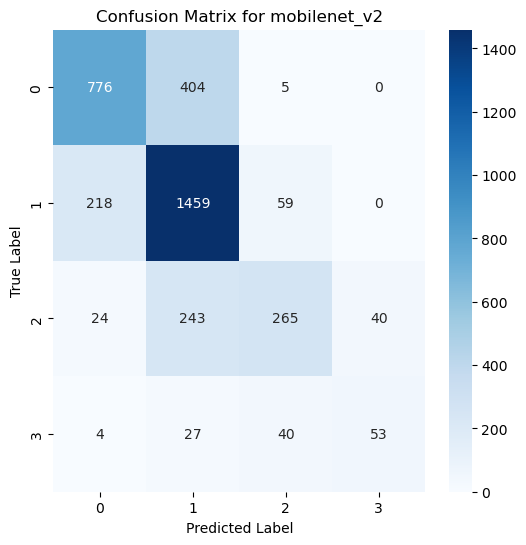

In [7]:
model_name = "mobilenet_v2"
print(f"\nTraining {model_name}...\n")
model = get_model(model_name)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

model = train_model(model, dataloaders, criterion, optimizer, model_name, num_epochs=10)
test_model(model, dataloaders["test"], model_name)

plot_confusion_matrix(model, dataloaders["test"], model_name)



Training resnet50...



/home/heemin.kang/software/miniforge3/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/heemin.kang/software/miniforge3/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10


/home/heemin.kang/software/miniforge3/envs/pytorch/lib/python3.12/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.8091 Acc: 0.6485
val Loss: 0.6907 Acc: 0.6988
Epoch 2/10
train Loss: 0.7316 Acc: 0.6766
val Loss: 0.7181 Acc: 0.6676
Epoch 3/10
train Loss: 0.7084 Acc: 0.6921
val Loss: 0.6793 Acc: 0.7055
Epoch 4/10
train Loss: 0.6998 Acc: 0.6926
val Loss: 0.6760 Acc: 0.6914
Epoch 5/10
train Loss: 0.6832 Acc: 0.7023
val Loss: 0.6688 Acc: 0.7024
Epoch 6/10
train Loss: 0.6857 Acc: 0.7012
val Loss: 0.6547 Acc: 0.7019
Epoch 7/10
train Loss: 0.6762 Acc: 0.7057
val Loss: 0.6899 Acc: 0.6861
Epoch 8/10
train Loss: 0.6788 Acc: 0.7039
val Loss: 0.6812 Acc: 0.6988
Epoch 9/10
train Loss: 0.6676 Acc: 0.7102
val Loss: 0.6636 Acc: 0.7069
Epoch 10/10
train Loss: 0.6571 Acc: 0.7160
val Loss: 0.6460 Acc: 0.7116
Best val Acc: 0.7116
Test Accuracy for resnet50: 72.38%


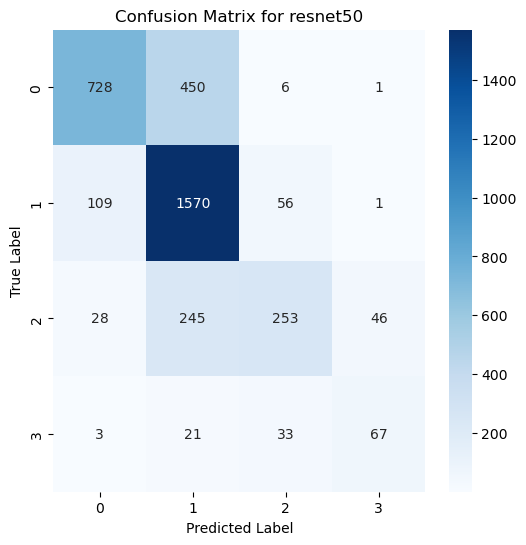

In [8]:
model_name = "resnet50"
print(f"\nTraining {model_name}...\n")
model = get_model(model_name)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

model = train_model(model, dataloaders, criterion, optimizer, model_name, num_epochs=10)
test_model(model, dataloaders["test"], model_name)

plot_confusion_matrix(model, dataloaders["test"], model_name)



Training efficientnet_b0...

Epoch 1/10


/home/heemin.kang/software/miniforge3/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/heemin.kang/software/miniforge3/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/heemin.kang/software/miniforge3/envs/pytorch/lib/python3.12/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLo

train Loss: 0.7751 Acc: 0.6654
val Loss: 0.6777 Acc: 0.6975
Epoch 2/10
train Loss: 0.6888 Acc: 0.6969
val Loss: 0.6705 Acc: 0.7080
Epoch 3/10
train Loss: 0.6461 Acc: 0.7147
val Loss: 0.6562 Acc: 0.7077
Epoch 4/10
train Loss: 0.6125 Acc: 0.7334
val Loss: 0.6726 Acc: 0.7002
Epoch 5/10
train Loss: 0.5973 Acc: 0.7360
val Loss: 0.6742 Acc: 0.7008
Epoch 6/10
train Loss: 0.5662 Acc: 0.7538
val Loss: 0.6883 Acc: 0.7113
Epoch 7/10
train Loss: 0.5388 Acc: 0.7681
val Loss: 0.6757 Acc: 0.7121
Epoch 8/10
train Loss: 0.5125 Acc: 0.7755
val Loss: 0.7137 Acc: 0.7044
Epoch 9/10
train Loss: 0.4756 Acc: 0.8008
val Loss: 0.7111 Acc: 0.7044
Epoch 10/10
train Loss: 0.4589 Acc: 0.8025
val Loss: 0.8159 Acc: 0.7044
Best val Acc: 0.7121
Test Accuracy for efficientnet_b0: 72.27%


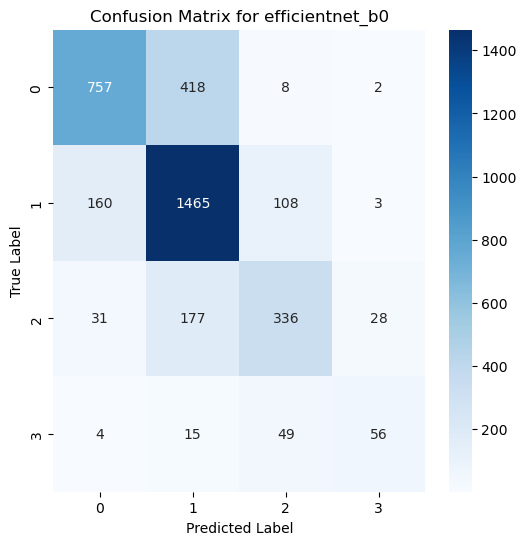

In [9]:
model_name = "efficientnet_b0"
print(f"\nTraining {model_name}...\n")
model = get_model(model_name)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

model = train_model(model, dataloaders, criterion, optimizer, model_name, num_epochs=10)
test_model(model, dataloaders["test"], model_name)

plot_confusion_matrix(model, dataloaders["test"], model_name)


In [45]:
import cv2

def denormalize_image(image_tensor):
    """ Convert a normalized tensor image back to its original form for visualization """
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    image = image_tensor.cpu().detach().numpy().transpose(1, 2, 0) 
    image = (image * std) + mean  # De-normalize
    image = np.clip(image, 0, 1)  # Clip to valid range [0,1]
    return (image * 255).astype(np.uint8)  # Convert to 8-bit format

# Grad-CAM Implementation
def grad_cam(model, image_tensor, target_layer, class_idx=None):
    model.eval()
    gradients = None
    activations = None
    
    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]
    
    def forward_hook(module, input, output):
        nonlocal activations
        activations = output
    
    # Register hooks
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_full_backward_hook(backward_hook)
    
    # Ensure image_tensor requires gradient
    image_tensor = image_tensor.unsqueeze(0).to(device).requires_grad_(True)  
    
    # Forward pass
    output = model(image_tensor)
    
    if class_idx is None:
        class_idx = output.argmax().item()
    
    # Backpropagate
    model.zero_grad()
    loss = output[0, class_idx]
    loss.backward()
    
    if gradients is None:
        raise ValueError("Gradients were not captured. Check if target_layer is correct.")
    
    # Compute Grad-CAM
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]
    
    heatmap = torch.mean(activations, dim=1).squeeze().cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)  # Normalize between 0 and 1
    
    # Convert heatmap to color
    heatmap = cv2.resize(heatmap, (224, 224))  # Resize to match original image size
    heatmap = np.uint8(255 * heatmap)  # Scale between 0-255
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply colormap
    
    # Convert original image using denormalization
    original_image = denormalize_image(image_tensor.squeeze(0))  
    
    # Blend heatmap with original image
    superimposed_img = cv2.addWeighted(original_image, 0.6, heatmap, 0.4, 0)
    
    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    plt.axis("off")
    plt.show()

    return superimposed_img

In [46]:
# Load trained model once
def load_trained_model(model_name):
    model = get_model(model_name)
    model.load_state_dict(torch.load(f"best_{model_name}.pth"))
    model.eval()

    # Select only the Conv2d layer inside the last convolutional block
    if model_name == "resnet50":
        target_layer = model.layer4[-1].conv3  # Last conv layer
    elif model_name == "mobilenet_v2":
        target_layer = model.features[-1][0]  # Select only the Conv2d layer
    elif model_name == "efficientnet_b0":
        target_layer = model.features[-1][0]  # Select only the Conv2d layer
    else:
        raise ValueError("Invalid model name!")

    return model, target_layer

# Apply Grad-CAM to multiple images
def apply_grad_cam_to_images(model, target_layer, num_images=3):
    sample_images = [test_dataset[i][0] for i in range(num_images)]  # Get test images
    for i, image in enumerate(sample_images):
        print(f"Grad-CAM for Test Image {i+1}")
        grad_cam(model, image, target_layer)



Applying Grad-CAM for mobilenet_v2...

Grad-CAM for Test Image 1


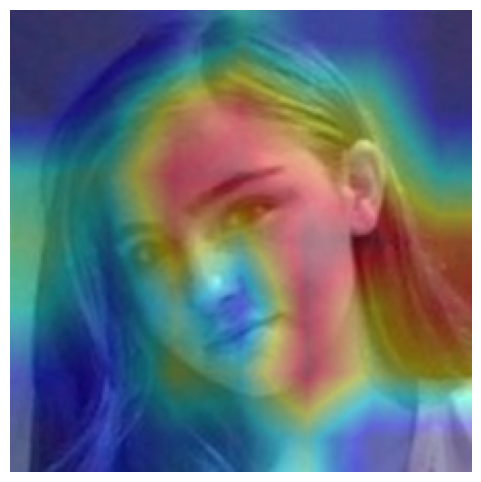

Grad-CAM for Test Image 2


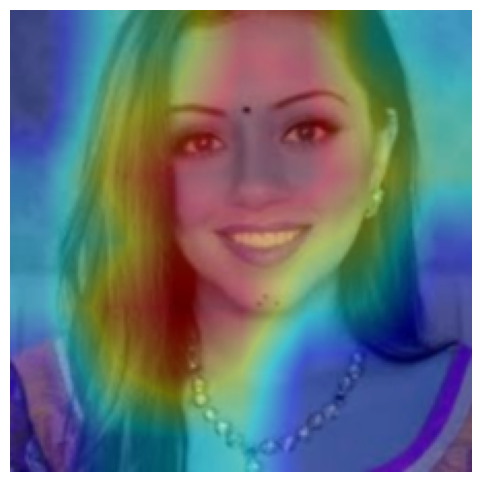

Grad-CAM for Test Image 3


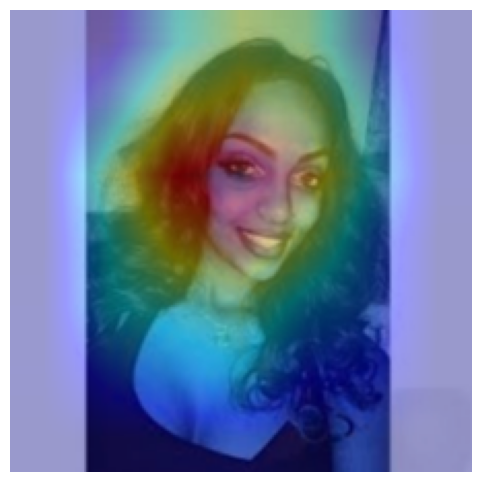


Applying Grad-CAM for resnet50...

Grad-CAM for Test Image 1


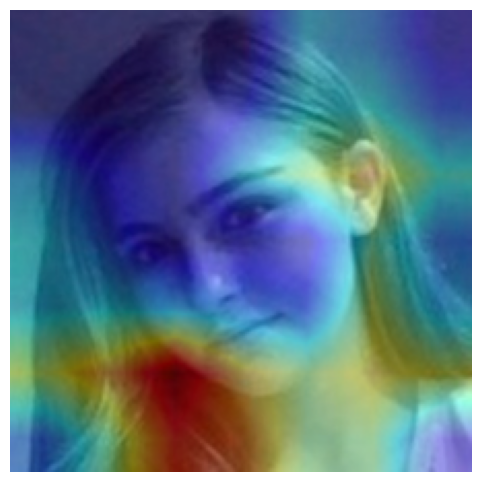

Grad-CAM for Test Image 2


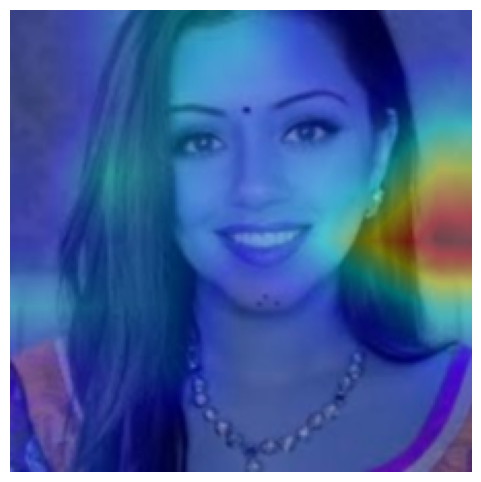

Grad-CAM for Test Image 3


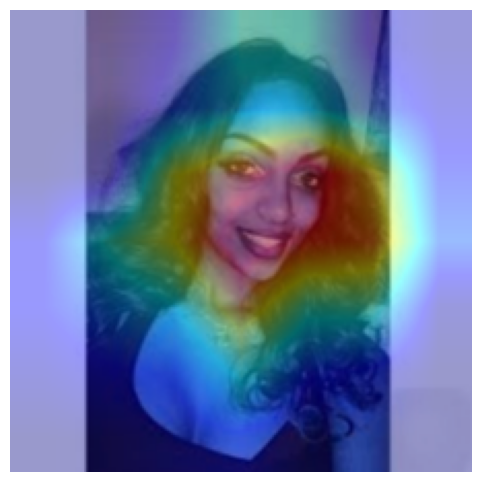


Applying Grad-CAM for efficientnet_b0...

Grad-CAM for Test Image 1


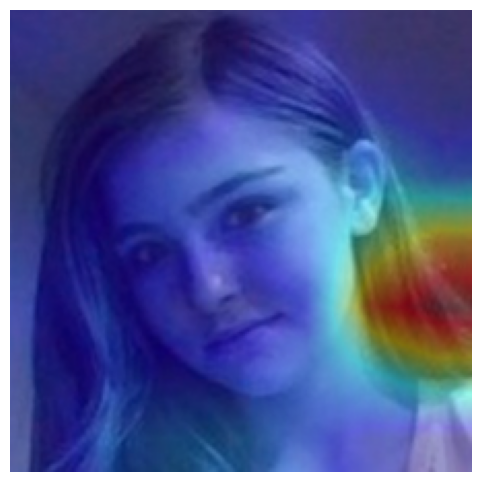

Grad-CAM for Test Image 2


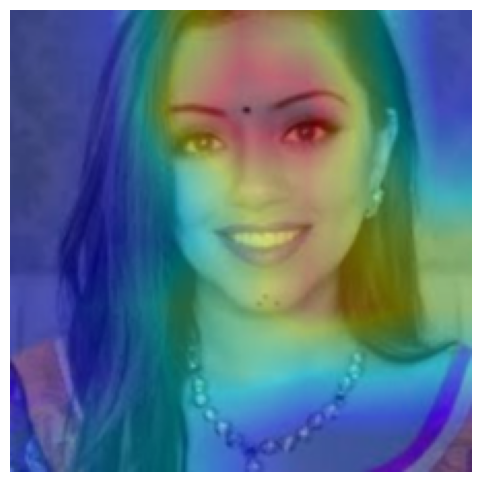

Grad-CAM for Test Image 3


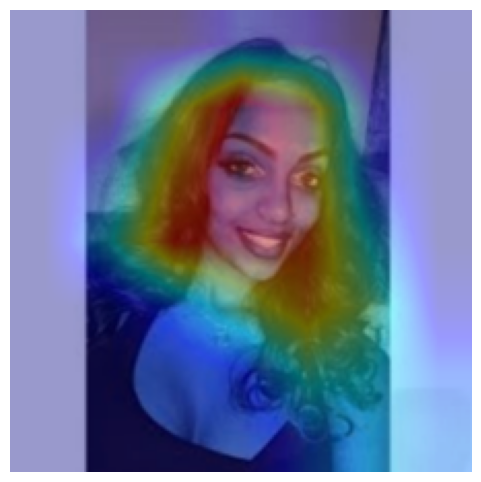

In [47]:
# Run Grad-CAM for each model
for model_name in ["mobilenet_v2", "resnet50", "efficientnet_b0"]:
    print(f"\nApplying Grad-CAM for {model_name}...\n")
    model, target_layer = load_trained_model(model_name)
    apply_grad_cam_to_images(model, target_layer, num_images=3)